In [2]:
from tbparse import SummaryReader
log_dir = "/scratch-shared/scur2012/trained_models/unet_attention/tb_logs"
reader = SummaryReader(log_dir)
df = reader.scalars
print(df)

      step                 tag     value
0       49               epoch  0.000000
1       99               epoch  0.000000
2      149               epoch  0.000000
3      199               epoch  0.000000
4      249               epoch  0.000000
...    ...                 ...       ...
6685  4999  val_loss_feature_5 -0.020931
6686  4999  val_loss_feature_6 -0.073235
6687  4999  val_loss_feature_7 -0.001982
6688  4999  val_loss_feature_8  0.000049
6689  4999  val_loss_feature_9 -0.065608

[6690 rows x 3 columns]


In [3]:
df[df['tag']=='epoch']

,step,tag,value
0,49,epoch,0.0
1,99,epoch,0.0
2,149,epoch,0.0
3,199,epoch,0.0
4,249,epoch,0.0
...,...,...,...
204,10199,epoch,1.0
205,10249,epoch,1.0
206,10299,epoch,1.0
207,10349,epoch,1.0


In [4]:
import duckdb

intrinsic_variables = ['mass_ratio', 'chirp_mass', 'theta_jn', 'phase', 'tilt_1', 'tilt_2', 'a_1', 'a_2', 'phi_12', 'phi_jl']
extrinsic_variables = ['luminosity_distance', 'dec', 'ra', 'psi', 'geocent_time']

with duckdb.connect(database=':memory:') as conn:
    df_main = conn.execute("""
        SELECT * 
        FROM df 
        WHERE tag = 'train_loss' OR tag = 'val_loss'
    """).df()
    
    df_val_loss_features = conn.execute(f"""
        SELECT step, value,
        CASE 
            {" ".join([f"WHEN tag = 'val_loss_feature_{i}' THEN '{name}'" for i,name in enumerate(
                intrinsic_variables+extrinsic_variables)])}
        END AS feature
        FROM df 
        WHERE tag LIKE 'val_loss_feature%'
    """).df()

    df_train_loss_features = conn.execute(f"""
        SELECT step, value,
        CASE 
            {" ".join([f"WHEN tag = 'train_loss_feature_{i}' THEN '{name}'" for i,name in enumerate(
                intrinsic_variables+extrinsic_variables)])}
        END AS feature
        FROM df 
        WHERE tag LIKE 'train_loss_feature%'
    """).df()
    
    df_features2 = conn.execute("""
        SELECT * 
        FROM df_val_loss_features 
        WHERE feature IN (
            SELECT feature
            FROM df_val_loss_features
            GROUP BY feature
            HAVING MIN(value) < -0.3
        )
    """).df()
    df_features1 = conn.execute("""
        SELECT * 
        FROM df_val_loss_features 
        WHERE feature IN (
            SELECT feature
            FROM df_val_loss_features
            GROUP BY feature
            HAVING MIN(value) BETWEEN -0.3 AND -0.005
        )
    """).df()
    
df_features1

,step,value,feature
0,4999,-0.201494,mass_ratio
1,4999,-0.198470,luminosity_distance
2,4999,-0.138631,theta_jn
3,4999,-0.097523,tilt_1
4,4999,-0.020931,tilt_2
5,4999,-0.073235,a_1
6,4999,-0.065608,phi_jl


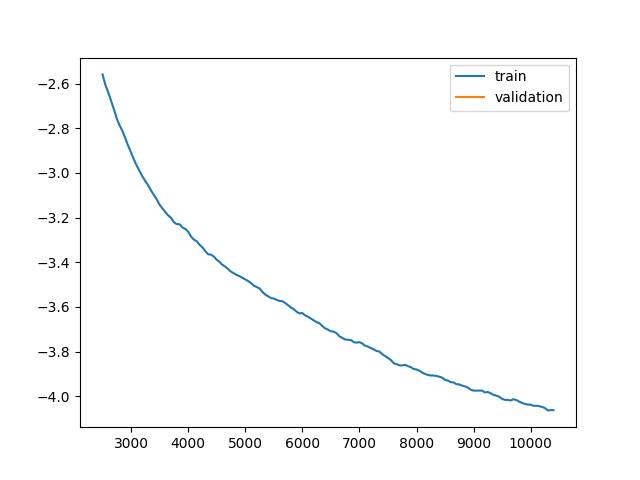

In [5]:
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns

train_loss = df_main[df_main['tag'] == 'train_loss'].copy()
train_loss['smoothed'] = train_loss['value'].rolling(50).mean()
val_loss = df_main[df_main['tag'] == 'val_loss']

plt.close(1), plt.figure(1)
plt.plot(train_loss['step'], train_loss['smoothed'], label='train')
plt.plot(val_loss['step'], val_loss['value'], label='validation')
plt.legend()

plt.show()

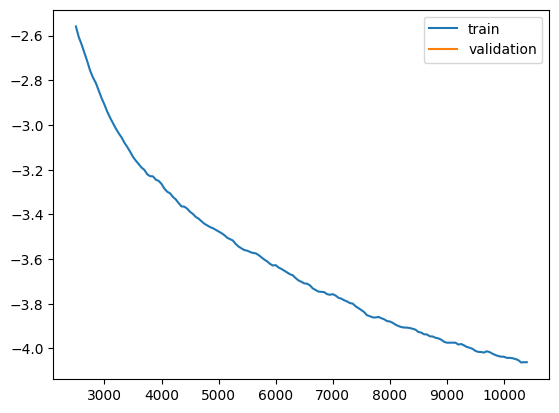

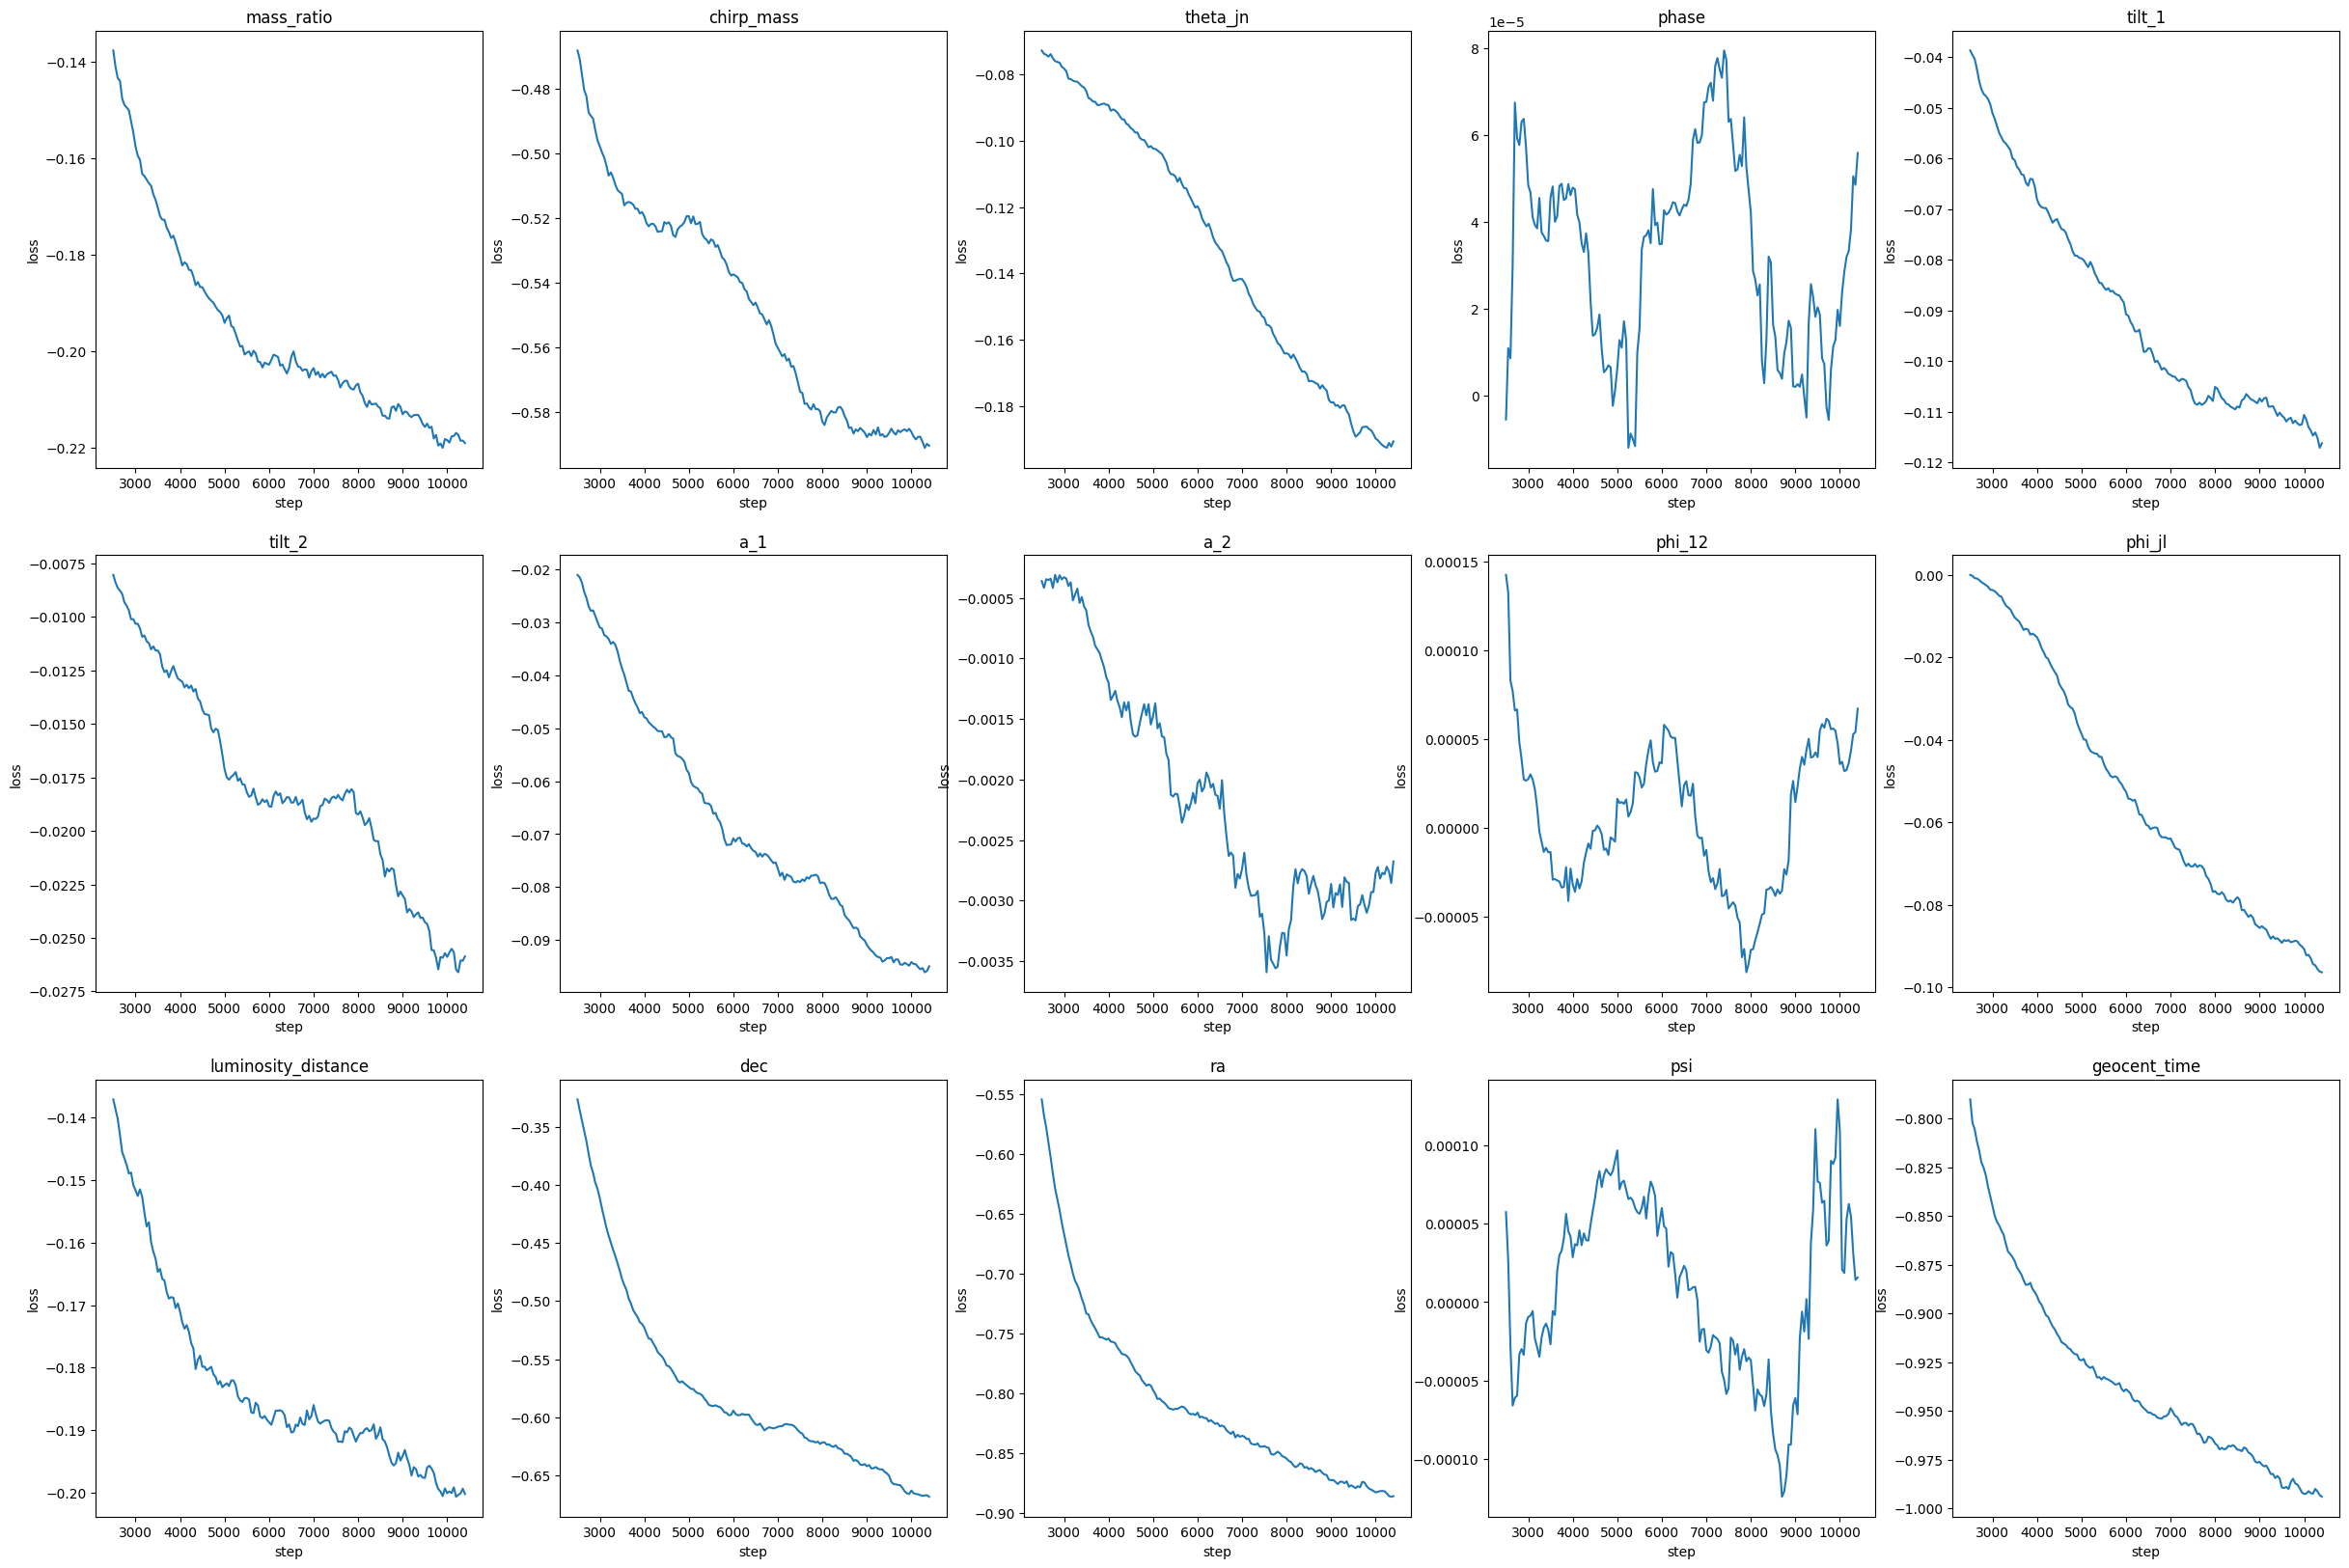

No such comm: 72509f1cd2214353b1213eac92734b7b


In [6]:
%matplotlib inline

plt.figure(2, figsize=(30, 20))
        
# Intrinsic variables plotting
for i, name in enumerate(intrinsic_variables+extrinsic_variables):
    ax = plt.subplot(3, 5, i + 1)
    plt.xlabel('step')
    plt.ylabel('loss')
    
    train_data = df_train_loss_features[df_train_loss_features['feature']==name].copy()
    train_data['smoothed'] = train_data['value'].rolling(50).mean()
    
    val_data = df_val_loss_features[df_val_loss_features['feature']==name]
    
    plt.title(name)
    plt.plot(train_data['step'], train_data['smoothed'], label='train')
    plt.plot(val_data['step'], val_data['value'], label='val')

<Axes: xlabel='step', ylabel='value'>

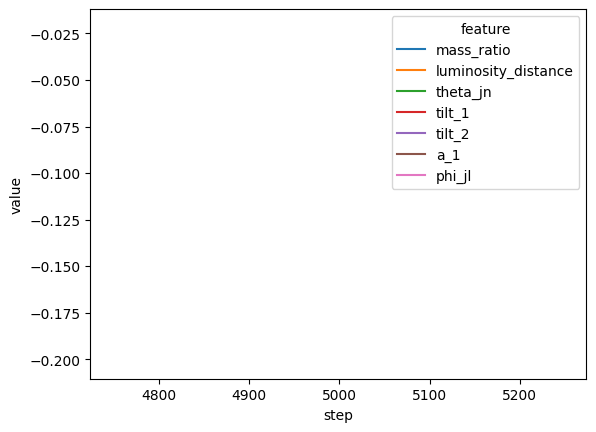

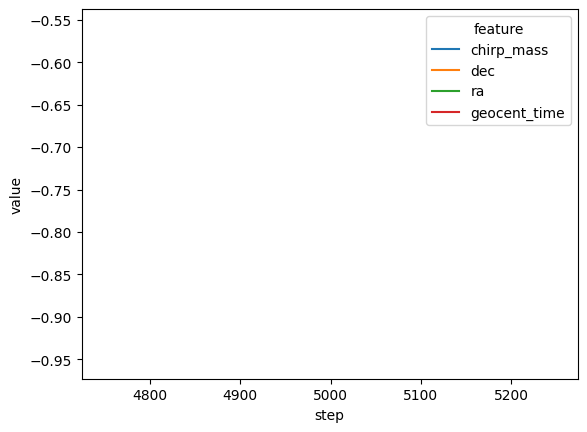

In [7]:
%matplotlib inline

plt.close(2), plt.figure(2)
sns.lineplot(data=df_features1, x='step', y='value', hue='feature')

plt.close(3), plt.figure(3)
sns.lineplot(data=df_features2, x='step', y='value', hue='feature')